# Mexican Peso Crisis 1994


# Mexican Peso Crisis 1994


## The Peso Problem

The **Mexican peso crisis** of December 1994 provides a classic example of carry trade risk. Throughout 1994, the Mexican peso offered attractive interest rates relative to the US dollar, making it a popular carry trade target. However, the peso's unexpected 50%+ devaluation in late December 1994 wiped out years of carry profits in a matter of days.

This crisis illustrates the fundamental risk in carry trades: **the carry component is typically small and steady, while the FX component can be large and sudden**.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas_datareader.data as web

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 13
plt.rcParams['legend.fontsize'] = 13

from cmds.portfolio import performanceMetrics, tailMetrics

## Data Collection

We collect three key series from FRED:
- **IRSTCI01MXM156N**: Mexican interest rate (1-month, % annual)
- **FEDFUNDS**: US Federal Funds rate (% annual) 
- **EXMXUS**: MXN/USD exchange rate (Mexican pesos per US dollar)

The analysis covers 1993-1996 to capture the pre-crisis buildup and post-crisis aftermath.


In [ ]:
# Data collection from FRED
start_date = '1993-01-01'
end_date = '1996-12-31'

# Mexican interest rate (1-month, % annual)
mx_rate = web.DataReader('IRSTCI01MXM156N', 'fred', start_date, end_date)
mx_rate.columns = ['MX_RATE']

# US Federal Funds rate (% annual)
us_rate = web.DataReader('FEDFUNDS', 'fred', start_date, end_date)
us_rate.columns = ['US_RATE']

# Exchange rate: MXN per USD
fx_rate = web.DataReader('EXMXUS', 'fred', start_date, end_date)
fx_rate.columns = ['MXN_USD']

print(f"Data coverage:")
print(f"Mexican rate: {mx_rate.index[0].strftime('%Y-%m-%d')} to {mx_rate.index[-1].strftime('%Y-%m-%d')}")
print(f"US rate: {us_rate.index[0].strftime('%Y-%m-%d')} to {us_rate.index[-1].strftime('%Y-%m-%d')}")
print(f"FX rate: {fx_rate.index[0].strftime('%Y-%m-%d')} to {fx_rate.index[-1].strftime('%Y-%m-%d')}")


Data coverage:
Mexican rate: 1993-01-01 to 1996-12-01
US rate: 1993-01-01 to 1996-12-01
FX rate: 1993-11-01 to 1996-12-01


In [ ]:
# Combine data and handle missing values
data = pd.concat([mx_rate, us_rate, fx_rate], axis=1)
data = data.dropna()

# Convert annual rates to monthly (approximately)
data['MX_RATE_MONTHLY'] = data['MX_RATE'] / 12 / 100  # Convert % annual to decimal monthly
data['US_RATE_MONTHLY'] = data['US_RATE'] / 12 / 100  # Convert % annual to decimal monthly

# Calculate monthly FX returns (MXN appreciation/depreciation)
data['FX_RETURN'] = data['MXN_USD'].pct_change()

print(f"Sample period: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
display(data.head().style.format('{:.2f}'))


Sample period: 1993-11-01 to 1996-12-01


## Visualizing the Crisis Setup


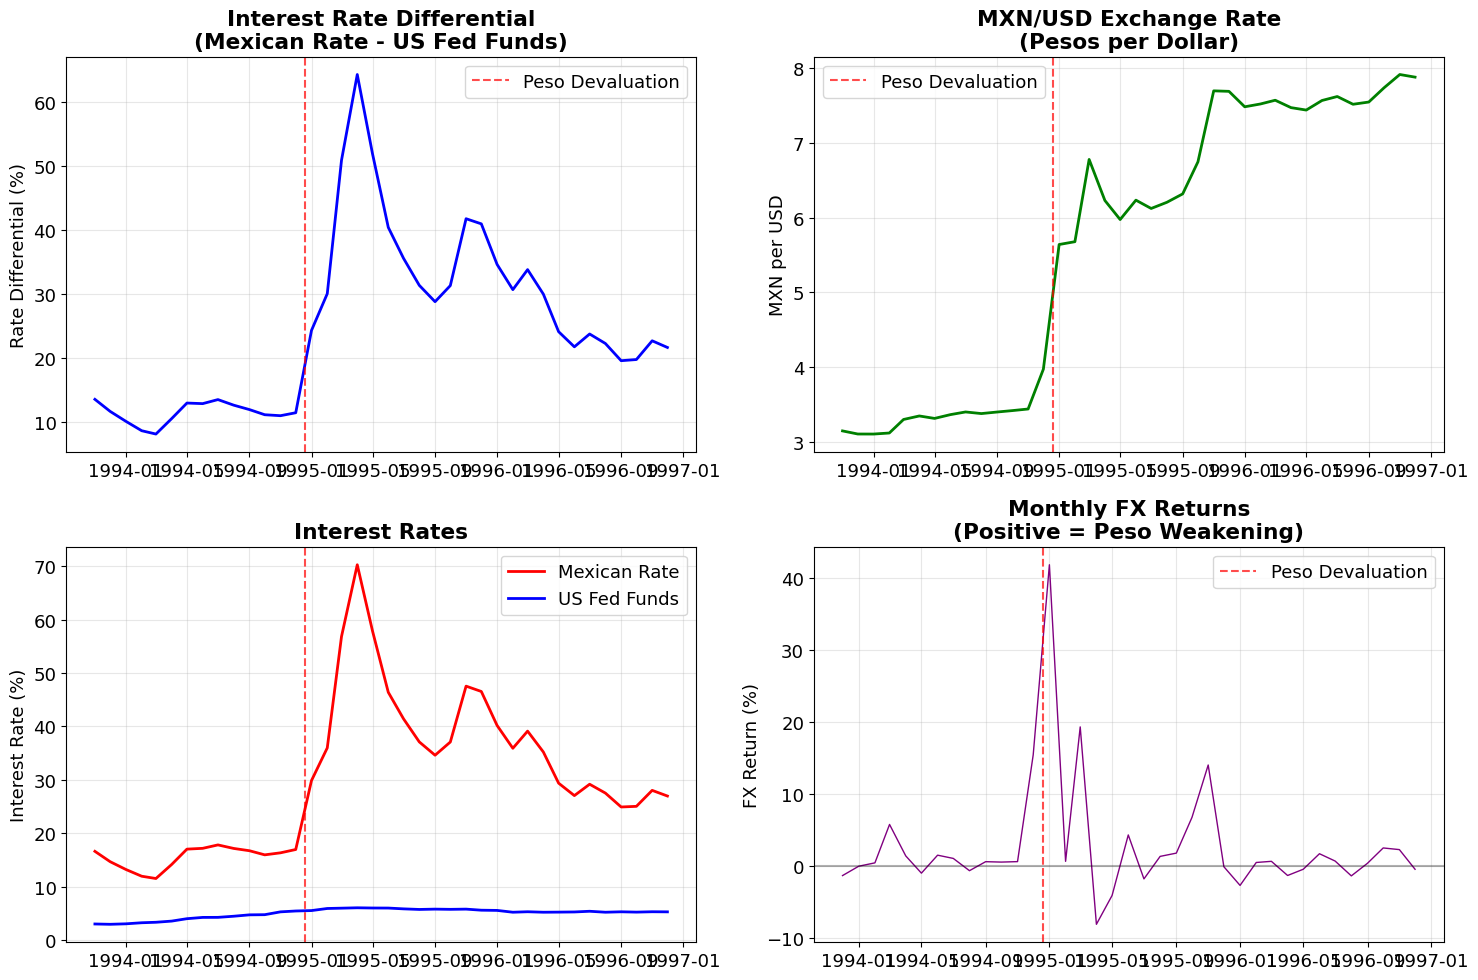


Crisis Statistics:
December 1994 FX return: 15.5% (peso weakening)
Pre-crisis average rate differential (1994): 11.3%
Exchange rate: 3.11 (Jan 1994) → 5.64 (Jan 1995)


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Interest rate differential
rate_diff = data['MX_RATE'] - data['US_RATE']
ax1.plot(data.index, rate_diff, 'b-', linewidth=2)
ax1.axvline(datetime(1994, 12, 20), color='red', linestyle='--', alpha=0.7, label='Peso Devaluation')
ax1.set_title('Interest Rate Differential\n(Mexican Rate - US Fed Funds)', fontweight='bold')
ax1.set_ylabel('Rate Differential (%)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Exchange rate
ax2.plot(data.index, data['MXN_USD'], 'g-', linewidth=2)
ax2.axvline(datetime(1994, 12, 20), color='red', linestyle='--', alpha=0.7, label='Peso Devaluation')
ax2.set_title('MXN/USD Exchange Rate\n(Pesos per Dollar)', fontweight='bold')
ax2.set_ylabel('MXN per USD')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Individual rates
ax3.plot(data.index, data['MX_RATE'], 'r-', linewidth=2, label='Mexican Rate')
ax3.plot(data.index, data['US_RATE'], 'b-', linewidth=2, label='US Fed Funds')
ax3.axvline(datetime(1994, 12, 20), color='red', linestyle='--', alpha=0.7)
ax3.set_title('Interest Rates', fontweight='bold')
ax3.set_ylabel('Interest Rate (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# FX monthly returns
ax4.plot(data.index[1:], data['FX_RETURN'][1:]*100, 'purple', linewidth=1)
ax4.axvline(datetime(1994, 12, 20), color='red', linestyle='--', alpha=0.7, label='Peso Devaluation')
ax4.axhline(0, color='black', linestyle='-', alpha=0.3)
ax4.set_title('Monthly FX Returns\n(Positive = Peso Weakening)', fontweight='bold')
ax4.set_ylabel('FX Return (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key statistics around the crisis
crisis_month = datetime(1994, 12, 1)
crisis_fx_return = data.loc[data.index >= crisis_month, 'FX_RETURN'].iloc[0] if len(data.loc[data.index >= crisis_month]) > 0 else np.nan

print(f"\nCrisis Statistics:")
if not np.isnan(crisis_fx_return):
    print(f"December 1994 FX return: {crisis_fx_return*100:.1f}% (peso weakening)")
print(f"Pre-crisis average rate differential (1994): {rate_diff['1994'].mean():.1f}%")
print(f"Exchange rate: {data.loc['1994-01', 'MXN_USD'].iloc[0]:.2f} (Jan 1994) → {data.loc['1995-01', 'MXN_USD'].iloc[0]:.2f} (Jan 1995)")


## Building the Carry Trade

The carry trade strategy:
1. **Borrow** in the low-yield currency (USD)
2. **Invest** in the high-yield currency (MXN) 
3. **Currency risk**: Exposed to MXN/USD exchange rate changes

**Monthly return decomposition:**
- **Carry component**: Interest rate differential earned
- **FX component**: Currency appreciation/depreciation
- **Total return**: Carry + FX components


In [ ]:
# Calculate carry trade returns
# Carry component: Interest rate differential (what we earn from rate difference)
data['CARRY_RETURN'] = data['MX_RATE_MONTHLY'] - data['US_RATE_MONTHLY']

# FX component: Currency moves (negative because MXN weakening hurts our position)
# When MXN_USD increases, peso weakens, which hurts our peso position
data['FX_COMPONENT'] = -data['FX_RETURN']

# Total return: Carry + FX components
data['TOTAL_RETURN'] = data['CARRY_RETURN'] + data['FX_COMPONENT']

# Calculate cumulative returns
data['CUM_CARRY'] = (1 + data['CARRY_RETURN']).cumprod() - 1
data['CUM_FX'] = (1 + data['FX_COMPONENT']).cumprod() - 1  
data['CUM_TOTAL'] = (1 + data['TOTAL_RETURN']).cumprod() - 1

print("Carry Trade Return Components:")
print(f"Average monthly carry: {data['CARRY_RETURN'].mean()*100:.2f}%")
print(f"Average monthly FX impact: {data['FX_COMPONENT'].mean()*100:.2f}%")
print(f"Average monthly total: {data['TOTAL_RETURN'].mean()*100:.2f}%")
print(f"\nVolatility (monthly):")
print(f"Carry volatility: {data['CARRY_RETURN'].std()*100:.2f}%")
print(f"FX volatility: {data['FX_COMPONENT'].std()*100:.2f}%")
print(f"Total volatility: {data['TOTAL_RETURN'].std()*100:.2f}%")


Carry Trade Return Components:
Average monthly carry: 2.06%
Average monthly FX impact: -2.79%
Average monthly total: -0.71%

Volatility (monthly):
Carry volatility: 1.13%
FX volatility: 8.34%
Total volatility: 8.42%


## Return Decomposition Analysis


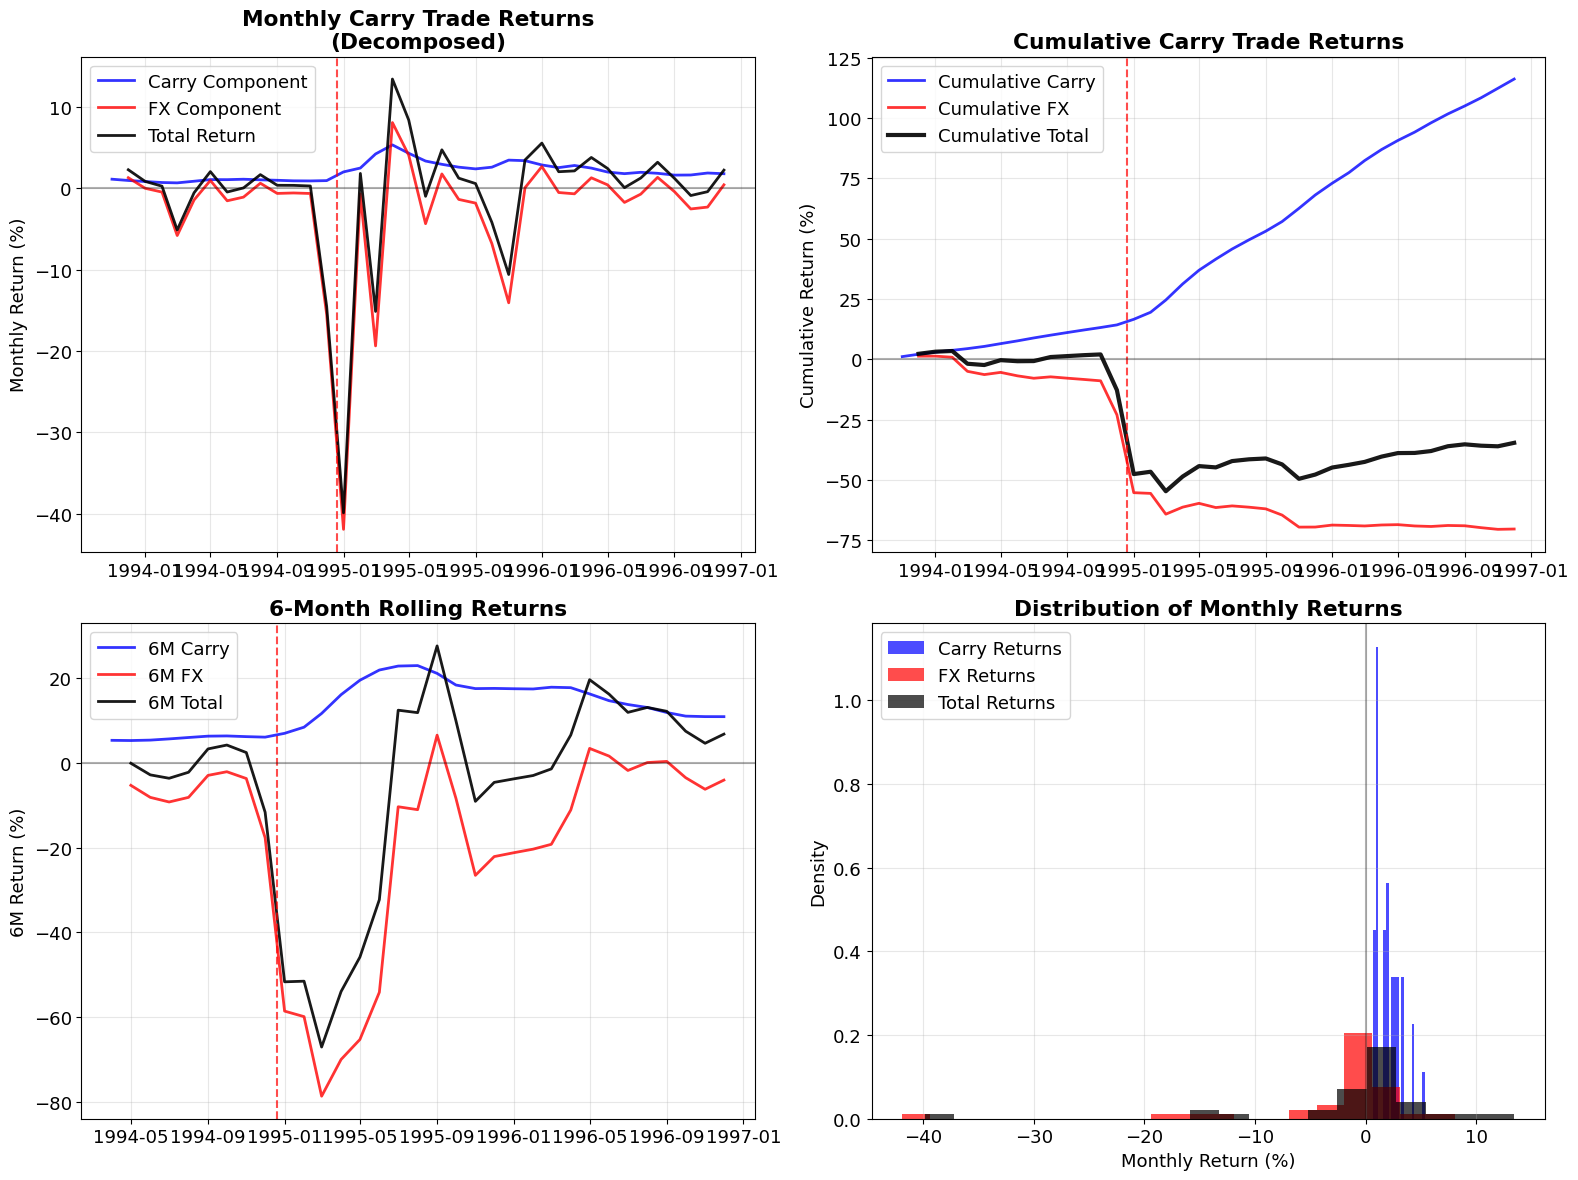

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Monthly returns decomposition
ax1.plot(data.index, data['CARRY_RETURN']*100, 'b-', linewidth=2, label='Carry Component', alpha=0.8)
ax1.plot(data.index, data['FX_COMPONENT']*100, 'r-', linewidth=2, label='FX Component', alpha=0.8)
ax1.plot(data.index, data['TOTAL_RETURN']*100, 'k-', linewidth=2, label='Total Return', alpha=0.9)
ax1.axvline(datetime(1994, 12, 20), color='red', linestyle='--', alpha=0.7)
ax1.axhline(0, color='black', linestyle='-', alpha=0.3)
ax1.set_title('Monthly Carry Trade Returns\n(Decomposed)', fontweight='bold')
ax1.set_ylabel('Monthly Return (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative returns
ax2.plot(data.index, data['CUM_CARRY']*100, 'b-', linewidth=2, label='Cumulative Carry', alpha=0.8)
ax2.plot(data.index, data['CUM_FX']*100, 'r-', linewidth=2, label='Cumulative FX', alpha=0.8)
ax2.plot(data.index, data['CUM_TOTAL']*100, 'k-', linewidth=3, label='Cumulative Total', alpha=0.9)
ax2.axvline(datetime(1994, 12, 20), color='red', linestyle='--', alpha=0.7)
ax2.axhline(0, color='black', linestyle='-', alpha=0.3)
ax2.set_title('Cumulative Carry Trade Returns', fontweight='bold')
ax2.set_ylabel('Cumulative Return (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Rolling 6-month performance
rolling_window = 6
rolling_carry = data['CARRY_RETURN'].rolling(window=rolling_window).sum()*100
rolling_fx = data['FX_COMPONENT'].rolling(window=rolling_window).sum()*100
rolling_total = data['TOTAL_RETURN'].rolling(window=rolling_window).sum()*100

ax3.plot(data.index, rolling_carry, 'b-', linewidth=2, label=f'{rolling_window}M Carry', alpha=0.8)
ax3.plot(data.index, rolling_fx, 'r-', linewidth=2, label=f'{rolling_window}M FX', alpha=0.8)
ax3.plot(data.index, rolling_total, 'k-', linewidth=2, label=f'{rolling_window}M Total', alpha=0.9)
ax3.axvline(datetime(1994, 12, 20), color='red', linestyle='--', alpha=0.7)
ax3.axhline(0, color='black', linestyle='-', alpha=0.3)
ax3.set_title(f'{rolling_window}-Month Rolling Returns', fontweight='bold')
ax3.set_ylabel('6M Return (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Distribution of monthly returns
ax4.hist(data['CARRY_RETURN']*100, bins=20, alpha=0.7, label='Carry Returns', density=True, color='blue')
ax4.hist(data['FX_COMPONENT']*100, bins=20, alpha=0.7, label='FX Returns', density=True, color='red')
ax4.hist(data['TOTAL_RETURN']*100, bins=20, alpha=0.7, label='Total Returns', density=True, color='black')
ax4.axvline(0, color='black', linestyle='-', alpha=0.3)
ax4.set_title('Distribution of Monthly Returns', fontweight='bold')
ax4.set_xlabel('Monthly Return (%)')
ax4.set_ylabel('Density')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Crisis Impact Analysis


In [ ]:
# Analyze the crisis period in detail
crisis_start = datetime(1994, 12, 1)
crisis_end = datetime(1995, 3, 31)

pre_crisis = data[data.index < crisis_start].copy()
crisis_period = data[(data.index >= crisis_start) & (data.index <= crisis_end)].copy()
post_crisis = data[data.index > crisis_end].copy()

print("=" * 60)
print("MEXICAN PESO CARRY TRADE CRISIS ANALYSIS")
print("=" * 60)

print(f"\nPRE-CRISIS PERIOD (Through Nov 1994):")
print(f"  Months: {len(pre_crisis)}")
print(f"  Cumulative carry earned: {pre_crisis['CUM_CARRY'].iloc[-1]*100:.1f}%")
print(f"  Cumulative FX impact: {pre_crisis['CUM_FX'].iloc[-1]*100:.1f}%")
print(f"  Cumulative total return: {pre_crisis['CUM_TOTAL'].iloc[-1]*100:.1f}%")
print(f"  Average monthly carry: {pre_crisis['CARRY_RETURN'].mean()*100:.2f}%")
print(f"  FX volatility: {pre_crisis['FX_COMPONENT'].std()*100:.2f}%")

print(f"\nCRISIS PERIOD (Dec 1994 - Mar 1995):")
print(f"  Months: {len(crisis_period)}")
if len(crisis_period) > 0:
    print(f"  Crisis period carry: {crisis_period['CARRY_RETURN'].sum()*100:.1f}%")
    print(f"  Crisis period FX impact: {crisis_period['FX_COMPONENT'].sum()*100:.1f}%")
    print(f"  Crisis period total: {crisis_period['TOTAL_RETURN'].sum()*100:.1f}%")
    print(f"  Worst monthly FX loss: {crisis_period['FX_COMPONENT'].min()*100:.1f}%")
    print(f"  Worst monthly total loss: {crisis_period['TOTAL_RETURN'].min()*100:.1f}%")

print(f"\nPOST-CRISIS PERIOD (Apr 1995 onwards):")
print(f"  Months: {len(post_crisis)}")
if len(post_crisis) > 0:
    post_crisis_total_from_start = (1 + post_crisis['TOTAL_RETURN']).cumprod().iloc[-1] - 1
    print(f"  Recovery total return: {post_crisis_total_from_start*100:.1f}%")
    print(f"  Average monthly carry: {post_crisis['CARRY_RETURN'].mean()*100:.2f}%")

print(f"\nOVERALL STRATEGY PERFORMANCE:")
final_carry = data['CUM_CARRY'].iloc[-1]*100
final_fx = data['CUM_FX'].iloc[-1]*100 
final_total = data['CUM_TOTAL'].iloc[-1]*100
print(f"  Total cumulative carry: {final_carry:.1f}%")
print(f"  Total cumulative FX: {final_fx:.1f}%")
print(f"  Total cumulative return: {final_total:.1f}%")

# Risk metrics
total_returns_monthly = data['TOTAL_RETURN'].dropna()
if len(total_returns_monthly) > 0:
    annual_return = (1 + total_returns_monthly.mean())**12 - 1
    annual_vol = total_returns_monthly.std() * np.sqrt(12)
    sharpe = annual_return / annual_vol if annual_vol > 0 else 0
    max_drawdown = ((1 + data['TOTAL_RETURN']).cumprod() / (1 + data['TOTAL_RETURN']).cumprod().cummax() - 1).min()
    
    print(f"\nRISK METRICS:")
    print(f"  Annualized return: {annual_return*100:.1f}%")
    print(f"  Annualized volatility: {annual_vol*100:.1f}%")
    print(f"  Sharpe ratio: {sharpe:.2f}")
    print(f"  Maximum drawdown: {max_drawdown*100:.1f}%")


MEXICAN PESO CARRY TRADE CRISIS ANALYSIS

PRE-CRISIS PERIOD (Through Nov 1994):
  Months: 13
  Cumulative carry earned: 13.2%
  Cumulative FX impact: -8.9%
  Cumulative total return: 2.0%
  Average monthly carry: 0.96%
  FX volatility: 1.82%

CRISIS PERIOD (Dec 1994 - Mar 1995):
  Months: 4
  Crisis period carry: 9.7%
  Crisis period FX impact: -77.4%
  Crisis period total: -67.7%
  Worst monthly FX loss: -41.9%
  Worst monthly total loss: -39.9%

POST-CRISIS PERIOD (Apr 1995 onwards):
  Months: 21
  Recovery total return: 44.2%
  Average monthly carry: 2.66%

OVERALL STRATEGY PERFORMANCE:
  Total cumulative carry: 116.2%
  Total cumulative FX: -70.3%
  Total cumulative return: -34.6%

RISK METRICS:
  Annualized return: -8.2%
  Annualized volatility: 29.2%
  Sharpe ratio: -0.28
  Maximum drawdown: -56.2%


## Key Lessons from the Peso Crisis


In [ ]:
# Calculate some key ratios to illustrate the lesson
avg_monthly_carry = data['CARRY_RETURN'].mean() * 100
worst_monthly_fx = data['FX_COMPONENT'].min() * 100
fx_vol = data['FX_COMPONENT'].std() * 100
carry_vol = data['CARRY_RETURN'].std() * 100

print("KEY INSIGHTS FROM THE PESO CRISIS:")
print("="*50)
print(f"\n1. ASYMMETRIC RISK PROFILE:")
print(f"   • Average monthly carry pickup: +{avg_monthly_carry:.2f}%")
print(f"   • Worst monthly FX loss: {worst_monthly_fx:.1f}%")
print(f"   • Risk-return asymmetry: {abs(worst_monthly_fx/avg_monthly_carry):.0f}:1")

print(f"\n2. VOLATILITY SOURCES:")
print(f"   • Carry component volatility: {carry_vol:.2f}%")
print(f"   • FX component volatility: {fx_vol:.2f}%")
print(f"   • FX risk dominates: {fx_vol/carry_vol:.0f}x higher")

print(f"\n3. TIME TO RECOVER:")
# Find when strategy recovers to pre-crisis peak
pre_crisis_peak = data.loc[data.index < crisis_start, 'CUM_TOTAL'].max()
recovery_data = data.loc[data.index >= crisis_start, 'CUM_TOTAL']
recovery_point = recovery_data[recovery_data >= pre_crisis_peak]

if len(recovery_point) > 0:
    recovery_date = recovery_point.index[0]
    months_to_recover = (recovery_date - crisis_start).days / 30.44
    print(f"   • Crisis began: {crisis_start.strftime('%b %Y')}")
    print(f"   • Strategy recovered: {recovery_date.strftime('%b %Y')}")
    print(f"   • Time to recovery: {months_to_recover:.1f} months")
else:
    print(f"   • Strategy never fully recovered during sample period")

print(f"\n4. CRISIS CHARACTERISTICS:")
print(f"   • Build-up period: Steady carry profits with low FX volatility")
print(f"   • Crisis trigger: Political/economic instability")
print(f"   • Crisis impact: Sudden, large FX move overwhelms carry")
print(f"   • Classic 'peso problem': Small probability, large impact event")


KEY INSIGHTS FROM THE PESO CRISIS:

1. ASYMMETRIC RISK PROFILE:
   • Average monthly carry pickup: +2.06%
   • Worst monthly FX loss: -41.9%
   • Risk-return asymmetry: 20:1

2. VOLATILITY SOURCES:
   • Carry component volatility: 1.13%
   • FX component volatility: 8.34%
   • FX risk dominates: 7x higher

3. TIME TO RECOVER:
   • Strategy never fully recovered during sample period

4. CRISIS CHARACTERISTICS:
   • Build-up period: Steady carry profits with low FX volatility
   • Crisis trigger: Political/economic instability
   • Crisis impact: Sudden, large FX move overwhelms carry
   • Classic 'peso problem': Small probability, large impact event


## Summary

The Mexican peso crisis of 1994 demonstrates the fundamental risk in carry trades:

**The Carry Trade Paradox:**
- **Carry component**: Small, steady, predictable
- **FX component**: Large, volatile, unpredictable
- **Result**: Years of carry profits can be wiped out in days

**Key Risk Factors:**
1. **Asymmetric payoffs**: Limited upside from carry, unlimited downside from FX
2. **Volatility mismatch**: FX volatility dominates carry stability
3. **Timing risk**: Crisis events are unpredictable and sudden
4. **Recovery time**: Long periods needed to recover from crisis losses

This case study illustrates why carry trades are often described as "picking up pennies in front of a steamroller" - the strategy collects small, regular profits most of the time, but faces the risk of large, sudden losses that can more than offset years of gains.
